# 대구광역시 식중독 발생 예측 및 예방대책 마련 (XGBoost, 엄선현)

In [39]:
import xgboost as xgb ## XGBoost 불러오기
from xgboost import plot_importance ## Feature Importance를 불러오기 위함
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

In [40]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_row', 100)

In [41]:
data = pd.read_csv("/Users/um/Desktop/식중독/데이터/식중독_전체_예측데이터.csv", engine='python', encoding='cp949')

In [42]:
data.head()

,년,월,계절,평균기온,최고기온,최저기온,평균운량,일강수량,일조시간,상대습도,평균풍속,월_1,월_2,월_3,월_4,월_5,월_6,월_7,월_8,월_9,월_10,월_11,월_12,중구,동구,서구,북구,남구,수성구,달서구,달성군,발생여부
0,2015,1,겨울,2.270968,6.812903,-1.719355,4.919760,0.777419,6.706452,56.574194,2.032258,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1
1,2015,2,겨울,3.832143,9.035714,-0.589286,4.919760,0.521429,6.982143,52.585714,2.246429,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2015,3,봄,9.187097,15.451613,3.338710,4.919760,1.629032,8.754839,45.496774,2.235484,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2015,4,봄,14.556667,20.216667,9.496667,4.755768,2.756667,6.163333,62.770000,2.256667,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
4,2015,5,봄,21.693548,27.980645,15.412903,4.919760,1.119355,9.987097,49.274194,2.000000,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1


In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 32 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   년       60 non-null     int64  
 1   월       60 non-null     int64  
 2   계절      60 non-null     object 
 3   평균기온    60 non-null     float64
 4   최고기온    60 non-null     float64
 5   최저기온    60 non-null     float64
 6   평균운량    60 non-null     float64
 7   일강수량    60 non-null     float64
 8   일조시간    60 non-null     float64
 9   상대습도    60 non-null     float64
 10  평균풍속    60 non-null     float64
 11  월_1     60 non-null     int64  
 12  월_2     60 non-null     int64  
 13  월_3     60 non-null     int64  
 14  월_4     60 non-null     int64  
 15  월_5     60 non-null     int64  
 16  월_6     60 non-null     int64  
 17  월_7     60 non-null     int64  
 18  월_8     60 non-null     int64  
 19  월_9     60 non-null     int64  
 20  월_10    60 non-null     int64  
 21  월_11    60 non-null     int64  
 22  월_12

In [44]:
data = pd.get_dummies(data, columns=["계절"])

In [45]:
x = data
y = data.loc[:, ["발생여부"]]

In [46]:
x.drop(["발생여부"], axis=1, inplace=True)

In [47]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 34 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   년       60 non-null     int64  
 1   월       60 non-null     int64  
 2   평균기온    60 non-null     float64
 3   최고기온    60 non-null     float64
 4   최저기온    60 non-null     float64
 5   평균운량    60 non-null     float64
 6   일강수량    60 non-null     float64
 7   일조시간    60 non-null     float64
 8   상대습도    60 non-null     float64
 9   평균풍속    60 non-null     float64
 10  월_1     60 non-null     int64  
 11  월_2     60 non-null     int64  
 12  월_3     60 non-null     int64  
 13  월_4     60 non-null     int64  
 14  월_5     60 non-null     int64  
 15  월_6     60 non-null     int64  
 16  월_7     60 non-null     int64  
 17  월_8     60 non-null     int64  
 18  월_9     60 non-null     int64  
 19  월_10    60 non-null     int64  
 20  월_11    60 non-null     int64  
 21  월_12    60 non-null     int64  
 22  중구  

In [48]:
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   발생여부    60 non-null     int64
dtypes: int64(1)
memory usage: 608.0 bytes


In [49]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=156)

In [50]:
print(x_train.shape, x_test.shape)

(48, 34) (12, 34)


In [51]:
print(len(x.columns))
print(len(y.columns))

34
1


In [76]:
y["발생여부"].value_counts()

1    44
0    16
Name: 발생여부, dtype: int64

In [52]:
dtrain = xgb.DMatrix(data=x_train, label=y_train)
dtest = xgb.DMatrix(data=x_test, label=y_test)

In [53]:
params = {'max_depth':3,
         'eta':0.1,
         'objective':'binary:logistic',
         'eval_metric':'logloss',
         'early_stoppings':100}

num_rounds=400

In [54]:
w_list = [(dtrain,'train'),(dtest,'test')]
xgb_model = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_rounds,\
                  early_stopping_rounds=100, evals=w_list)

[0]	train-logloss:0.651157	test-logloss:0.665051
Multiple eval metrics have been passed: 'test-logloss' will be used for early stopping.

Will train until test-logloss hasn't improved in 100 rounds.
[1]	train-logloss:0.614873	test-logloss:0.641203
[2]	train-logloss:0.583299	test-logloss:0.620814
[3]	train-logloss:0.555661	test-logloss:0.603275
[4]	train-logloss:0.531343	test-logloss:0.588102
[5]	train-logloss:0.50985	test-logloss:0.574911
[6]	train-logloss:0.49087	test-logloss:0.554488
[7]	train-logloss:0.470094	test-logloss:0.537651
[8]	train-logloss:0.45318	test-logloss:0.528191
[9]	train-logloss:0.439118	test-logloss:0.518101
[10]	train-logloss:0.421969	test-logloss:0.511442
[11]	train-logloss:0.406066	test-logloss:0.510912
[12]	train-logloss:0.39319	test-logloss:0.504642
[13]	train-logloss:0.378903	test-logloss:0.493548
[14]	train-logloss:0.36611	test-logloss:0.483681
[15]	train-logloss:0.356857	test-logloss:0.478517
[16]	train-logloss:0.347225	test-logloss:0.475445
[17]	train-logl

In [55]:
pred_probs = xgb_model.predict(dtest)
print('predict() 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨')
print(np.round(pred_probs[:10], 3))

# 예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값 결정해 리스트 객체인 preds에 저장
preds = [ 1 if x > 0.5 else 0 for x in pred_probs]
print('예측값 10개만 표시: ', preds[:10])

predict() 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨
[0.685 0.456 0.842 0.759 0.904 0.136 0.499 0.604 0.846 0.905]
예측값 10개만 표시:  [1, 0, 1, 1, 1, 0, 0, 1, 1, 1]


In [80]:
def get_clf_eval(y_test, y_pred):
    confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred)
    AUC = roc_auc_score(y_test, y_pred)
    print('오차행렬:\n', confusion)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))
    print('AUC: {:.4f}'.format(AUC))


In [81]:
get_clf_eval(y_test, preds)

오차행렬:
 [[2 0]
 [1 9]]

정확도: 0.9167
정밀도: 1.0000
재현율: 0.9000
F1: 0.9474
AUC: 0.9500


In [82]:
y_test

,발생여부
39,1
46,0
28,1
26,1
9,1
49,1
57,0
7,1
3,1
6,1


In [85]:
preds

[1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1]

In [86]:
from sklearn.metrics import classification_report
print(classification_report(y_test, preds, target_names=['발생X', '발생O']))

              precision    recall  f1-score   support

         발생X       0.67      1.00      0.80         2
         발생O       1.00      0.90      0.95        10

    accuracy                           0.92        12
   macro avg       0.83      0.95      0.87        12
weighted avg       0.94      0.92      0.92        12



In [87]:
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
rc('font', family='AppleGothic')

plt.rcParams['axes.unicode_minus'] = False

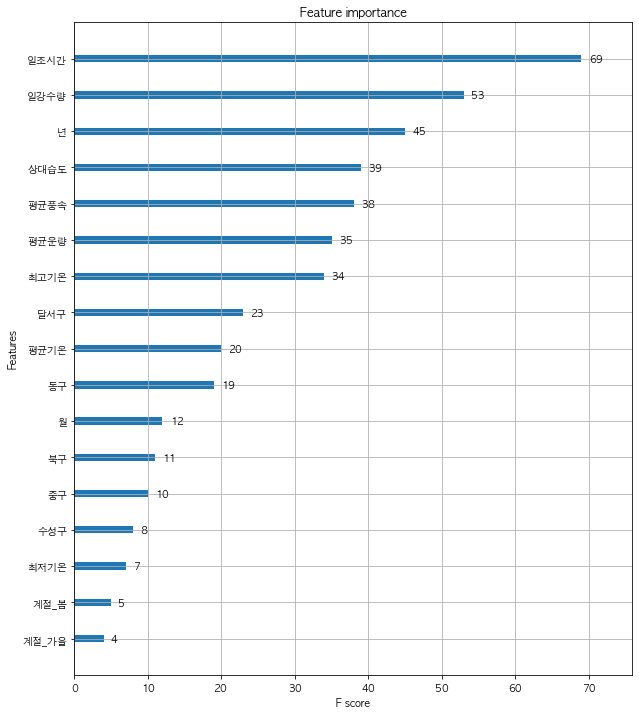

In [88]:
from xgboost import plot_importance
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model, ax=ax)